# Распознавание ключевых слов: использование речевых формант в качестве входных параметров модели 

Пример ноутбука, распознающего слова "down", "go", "left", "no", "right", "stop", "up", "yes", используя форманты в качестве фичей

## Установка библиотек

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn import preprocessing as skl_prepr

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from scipy.signal import find_peaks
from scipy.signal import welch

import python_speech_features as psf

from pydub import AudioSegment

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
print(tf.__version__, np.__version__)

2.7.0 1.19.5


## Импорт датасета Google Speech Commands

Используется малый датасет для настройки алгоритма

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Shuffle файлов

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\right\\b5d1e505_nohash_0.wav', shape=(), dtype=string)


Train/test/validate-split

In [6]:
train_ex = 6400
test_ex = 800
val_ex = 800

train_files = filenames[:train_ex]
val_files = filenames[train_ex : train_ex + test_ex]
test_files = filenames[train_ex + test_ex : train_ex + test_ex + val_ex]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Заливка аудиофайлов

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

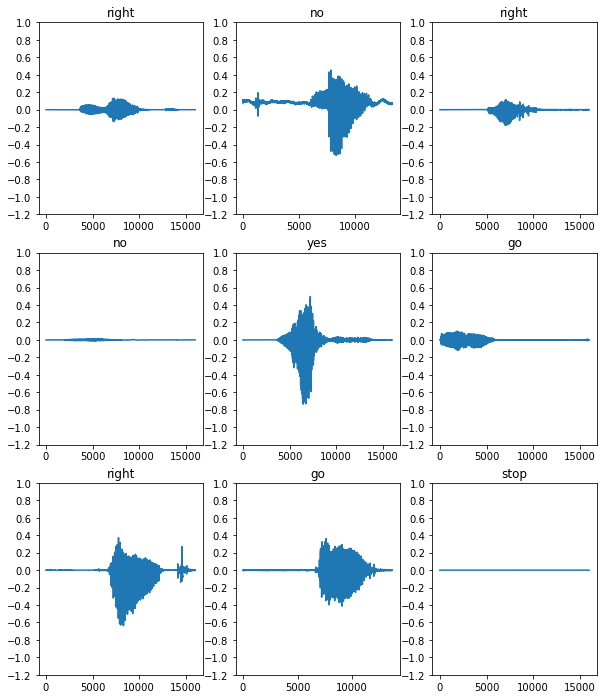

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Спектрограммы

Блок с исследованием спектрограмм сигналов

In [12]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)


print(tf.shape(waveform))

d = tf.shape(waveform)
test = tf.cast(AudioSegment.silent(duration = (16000 - d) * 1000 / 16000, frame_rate = 16000).get_array_of_samples(), tf.float32)

print(test.shape)

waveform = tf.cast(waveform, tf.float32)
wp = tf.concat([waveform, test], 0)

print(tf.shape(wp))

wp = tf.cast(wp, tf.float32)



tf.Tensor([16000], shape=(1,), dtype=int32)
(0,)
tf.Tensor([16000], shape=(1,), dtype=int32)


In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  #print(spectrogram.shape)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

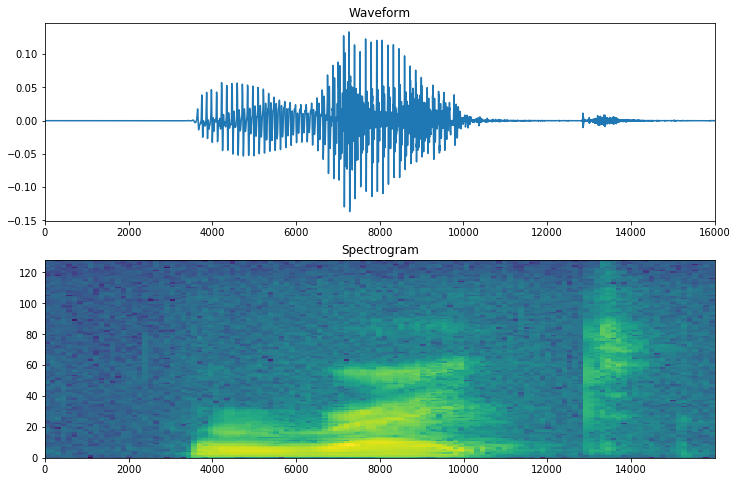

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [18]:
formant_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Спектрограммы различных сигналов + паддинг

0 (124, 129, 1)
1 (124, 129, 1)
2 (124, 129, 1)
3 (124, 129, 1)
4 (124, 129, 1)
5 (124, 129, 1)
6 (124, 129, 1)
7 (124, 129, 1)
8 (124, 129, 1)


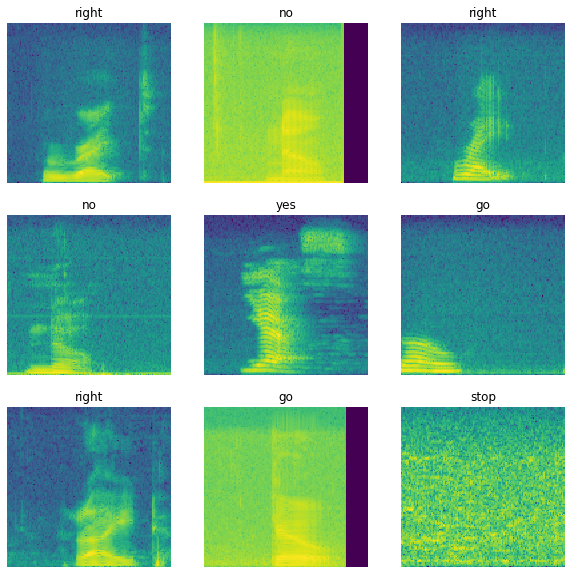

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(formant_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  print(i, spectrogram.shape)
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Извлечение фичей
Представлены 2 варианта подготовки фичей
1) из полученных STFT выбираются три максимальных пика. Далее из всего вектора STFT извлекаются окрестности пиков, остальные параметры зануляются - подготовленный вектор отправляется на вход нейронной сети
2) Во втором варианте - из пиковых значений выбираются три агрегированных характеристики - среднее, дисперсия и положение в спектре, таким образом на вход нейронной сети на каждый слайс подается 9 значений

In [42]:
def get_fourier(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    wave_stft = tf.signal.stft(
        equal_length, frame_length=1024, frame_step=512, fft_length = 129)
    wave_stft = tf.abs(wave_stft)
    return wave_stft

In [43]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  feat_ = get_fourier(waveform)
  print(label, feat_.shape, feat_[:1])

right (30, 65) tf.Tensor(
[[1.46194607e-05 2.37525928e-05 3.81543286e-05 2.79305896e-05
  1.40821703e-05 1.01268715e-05 5.20739832e-06 6.08267555e-06
  1.17547588e-05 1.92995740e-05 1.76138929e-05 9.27210021e-06
  4.83816757e-06 9.97822463e-06 1.75503901e-05 1.45714093e-05
  1.65144661e-06 1.79388644e-05 1.26138457e-05 1.22962556e-05
  1.48908930e-05 8.79216987e-06 1.07862379e-05 2.26008779e-05
  2.63521342e-05 1.80699881e-05 4.18103218e-06 9.00901341e-06
  1.15580633e-05 2.34229101e-05 1.91874697e-05 1.51992781e-05
  1.30207918e-05 1.01418273e-05 8.18246372e-06 1.29828686e-05
  1.02263875e-05 3.53599648e-06 8.38917276e-06 7.64507058e-06
  1.80736624e-05 1.21860357e-05 1.59838271e-06 1.12758444e-05
  8.00390808e-06 1.05842037e-05 8.95693847e-06 2.27431542e-06
  1.62712640e-05 1.25301431e-05 1.83852296e-06 3.06833203e-06
  2.77887739e-06 9.01919157e-06 6.69683686e-06 4.42756436e-06
  4.90927414e-06 5.35547133e-06 5.33202274e-06 5.07855930e-06
  4.85967166e-06 7.25782593e-06 8.40453049e-

[ 2  9 14 17 20 24 29 35 38 40 43 45 48 51 53 57 62]


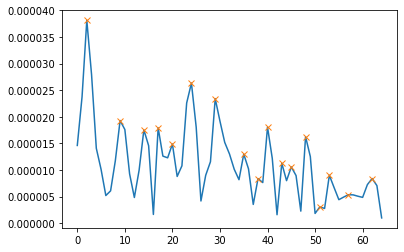

In [44]:

x = feat_[:1].numpy().flatten()

peaks, properties = find_peaks(x, height=0)
#peaks = peaks[0::2]
print(peaks)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()


In [68]:
def local_extract_peaks(arr):
    peaks, properties = find_peaks(arr, height = 0)
    
    arr_inp = np.zeros(arr.shape)
    arr_inp.put(peaks, arr[peaks])

    ind = np.argpartition(arr_inp, -3)[-3:]

    ind_full = list(ind)

    for i in ind:
        # print(i)
        for k in range(-3, 4):
            if k != 0 and i + k >= 0 and i + k <= 64:
                ind_full.append(i + k)
    arr_out = np.zeros(arr.shape)
    arr_out.put(ind_full, arr[ind_full])
    return arr_out, ind


Иллюстрация разметки пиков

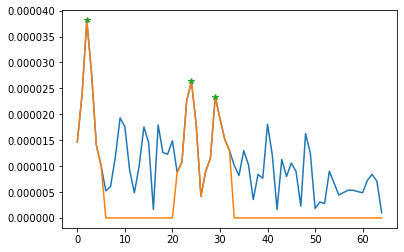

In [69]:
z = feat_[:1].numpy().flatten()
x, ind = local_extract_peaks(z)
plt.plot(z)
plt.plot(x)
plt.plot(ind, x[ind], "*")
plt.show()

In [70]:
def gaussian_fit(arr, index_):
    left = arr[max(0,index_-3):index_]
    right= arr[index_:3+index_+1]

    arr_in = np.concatenate((left, right), axis = 0)
    
    
    # print(arr_in)
    avg = np.mean(arr_in)
    var = np.var(arr_in)
    pdf_x = np.linspace(max(index_ - 3, 0), min(index_ + 3, arr.shape[0]), num = 7)
    pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
    # print(pdf_x, pdf_y)
    return avg, var, pdf_x, pdf_y



Извлечение агрегированных статистик

29 1.3654079793923302e-05 3.49350997301489e-11
24 1.4255921931700349e-05 5.734692688218597e-11
2 2.1444335591998726e-05 9.258146636412295e-11


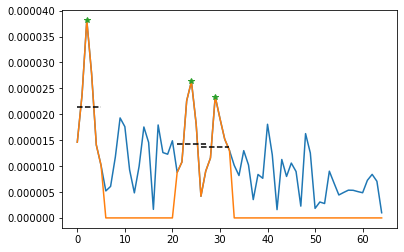

In [71]:
z = feat_[:1].numpy().flatten()
x, ind = local_extract_peaks(z)
plt.plot(z)
plt.plot(x)
plt.plot(ind, x[ind], "*")

for i in ind:
    m, d, xx, y = gaussian_fit(x, i)
    print(i, m, d)
    plt.plot(xx, np.full(xx.shape, m), 'k--')
    # plt.plot(xx, y, 'k--')
plt.show()

In [72]:
def filter_peaks_stft(arr):
    arr_, _ = local_extract_peaks(arr)
    return arr_

In [73]:
def filter_peaks_stft_apply(waveform, label):
    inp_arr = waveform.numpy()
    features_init = get_fourier(waveform)
    features = tf.convert_to_tensor(np.apply_along_axis(filter_peaks_stft, 1, features_init), dtype=tf.float32)
    
    label_id = tf.argmax(label == commands)
    #print('label_id : ', label_id, ' features : ', features.shape)
    del inp_arr

    return features, label_id

In [74]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  label = label.numpy().decode('utf-8')
  f_, l_ = filter_peaks_stft_apply(waveform, label)
  print(f_.shape, l_.shape)



(30, 65) ()


In [75]:
def filter_peaks_stft_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = filter_peaks_stft_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = tf.reshape(wv, shape=(1950,))
    return wv, lbl


In [76]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = filter_peaks_stft_outside_function(waveform, label)
  print(wv.shape, label_)

(1950,) tf.Tensor(4, shape=(), dtype=int64)


In [77]:
def filter_peaks_stft_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(filter_peaks_stft_outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [78]:
train_ds = filter_peaks_stft_preprocess_dataset(train_files)
val_ds = filter_peaks_stft_preprocess_dataset(val_files)
test_ds = filter_peaks_stft_preprocess_dataset(test_files)

whole_ds = filter_peaks_stft_preprocess_dataset(filenames)

In [79]:
def plot_filtered_stft(features, ax):
  features = tf.reshape(features, shape = (30, 65))
  height = features.shape[0]
  width = features.shape[1]
  X = np.linspace(0, np.size(features), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, features)

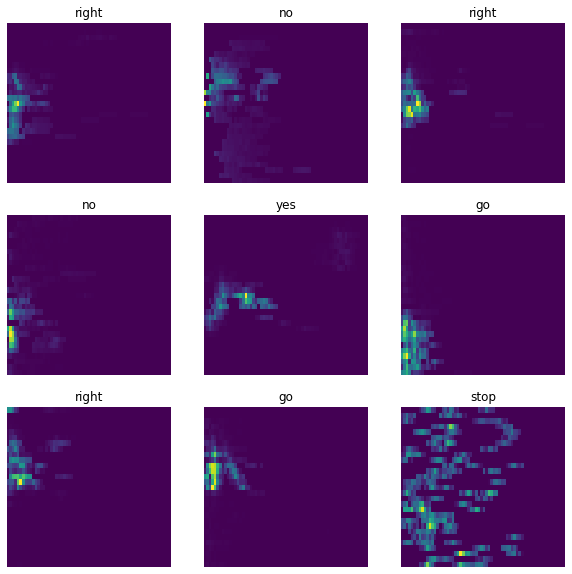

In [80]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (features, label_id) in enumerate(whole_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_filtered_stft(features.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [81]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [82]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
print(train_ds.take(1))

<TakeDataset shapes: ((None, 1950), <unknown>), types: (tf.float32, tf.int64)>


### Инициализация и обучение модели (Full Dense-NN) над отфильтрованными STFT

Размерность входного слоя - 129 * 124 (размерность STFT x количество окон)

In [83]:
for elem, _ in whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (1950,)
8


In [84]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(1950, activation='relu', name = 'dense_init'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu', name = 'dense_256'),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu', name = 'dense_128'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu', name = 'dense_64'),
    layers.Dropout(0.15),
    layers.Dense(num_labels, activation = 'softmax', name = 'softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_init (Dense)          (None, 1950)              3804450   
                                                                 
 dropout_8 (Dropout)         (None, 1950)              0         
                                                                 
 dense_256 (Dense)           (None, 256)               499456    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_128 (Dense)           (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)               

In [85]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [86]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 105s 1s/step - loss: 1.7993 - categorical_accuracy: 0.0966 - val_loss: 1.4932 - val_categorical_accuracy: 0.0812
Epoch 2/10
100/100 [==============================] - 5s 48ms/step - loss: 1.3489 - categorical_accuracy: 0.0862 - val_loss: 1.2672 - val_categorical_accuracy: 0.0737
Epoch 3/10
100/100 [==============================] - 5s 49ms/step - loss: 1.0606 - categorical_accuracy: 0.0842 - val_loss: 1.1170 - val_categorical_accuracy: 0.0763
Epoch 4/10
100/100 [==============================] - 5s 51ms/step - loss: 0.8406 - categorical_accuracy: 0.0875 - val_loss: 1.0845 - val_categorical_accuracy: 0.0763
Epoch 5/10
100/100 [==============================] - 5s 51ms/step - loss: 0.6926 - categorical_accuracy: 0.0898 - val_loss: 1.1225 - val_categorical_accuracy: 0.0763
Epoch 6/10
100/100 [==============================] - 5s 50ms/step - loss: 0.6128 - categorical_accuracy: 0.0864 - val_loss: 1.0840 - val_categorical_accuracy: 0.071

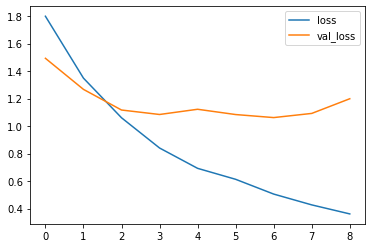

In [87]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Тестирование

In [88]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [89]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 70%


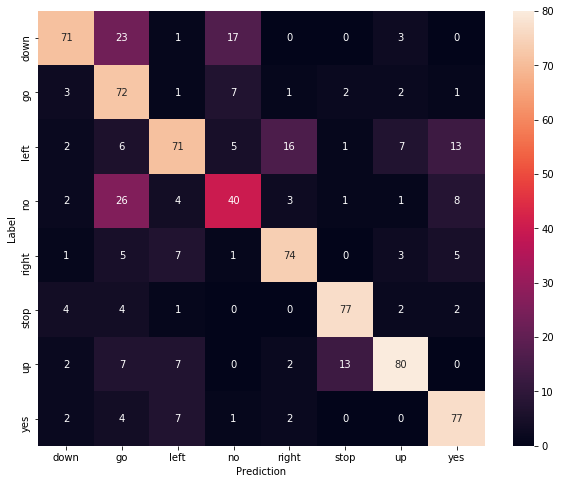

In [90]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

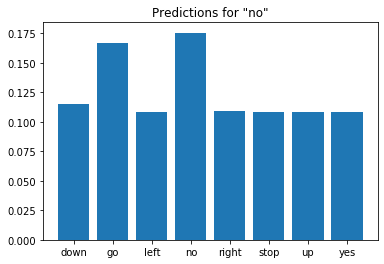

In [91]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = filter_peaks_stft_preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

### Сверточная сеть над изображениями

In [98]:
def filter_peaks2d_stft_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = filter_peaks_stft_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = wv[..., tf.newaxis]
    wv = tf.reshape(wv, shape = (30, 65, 1))
    return wv, lbl


In [99]:
def filter_peaks2d_stft_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(filter_peaks2d_stft_outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [100]:
train_ds_2d = filter_peaks2d_stft_preprocess_dataset(train_files)
val_ds_2d = filter_peaks2d_stft_preprocess_dataset(val_files)
test_ds_2d = filter_peaks2d_stft_preprocess_dataset(test_files)

whole_ds_2d = filter_peaks2d_stft_preprocess_dataset(filenames)

In [101]:
batch_size = 64
train_ds_2d = train_ds_2d.batch(batch_size)
val_ds_2d = val_ds_2d.batch(batch_size)

In [102]:
train_ds_2d = train_ds_2d.cache().prefetch(AUTOTUNE)
val_ds_2d = val_ds_2d.cache().prefetch(AUTOTUNE)
print(train_ds_2d.take(1))

<TakeDataset shapes: ((None, 30, 65, 1), <unknown>), types: (tf.float32, tf.int64)>


In [103]:
for elem, _ in whole_ds_2d.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (30, 65, 1)
8


In [104]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=whole_ds_2d.map(map_func=lambda spec, label: spec))

In [105]:
model_2d = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    norm_layer,
    layers.Resizing(32, 32),
    # Normalize.
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_2d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 30, 65, 1)        3         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)       

In [106]:
model_2d.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [107]:
EPOCHS = 10
history = model_2d.fit(
    train_ds_2d, 
    validation_data=val_ds_2d,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 147s 1s/step - loss: 4.1928 - categorical_accuracy: 0.0778 - val_loss: 2.0610 - val_categorical_accuracy: 0.0938
Epoch 2/10
100/100 [==============================] - 20s 202ms/step - loss: 2.3375 - categorical_accuracy: 0.0855 - val_loss: 2.0569 - val_categorical_accuracy: 0.0525
Epoch 3/10
100/100 [==============================] - 25s 252ms/step - loss: 2.3329 - categorical_accuracy: 0.1055 - val_loss: 2.2190 - val_categorical_accuracy: 0.0600
Epoch 4/10
100/100 [==============================] - 28s 279ms/step - loss: 2.4065 - categorical_accuracy: 0.0913 - val_loss: 1.9644 - val_categorical_accuracy: 0.0787
Epoch 5/10
100/100 [==============================] - 30s 296ms/step - loss: 2.7570 - categorical_accuracy: 0.0825 - val_loss: 2.0794 - val_categorical_accuracy: 0.0262
Epoch 6/10
100/100 [==============================] - 22s 216ms/step - loss: 2.2411 - categorical_accuracy: 0.0891 - val_loss: 2.0794 - val_categorical_accur

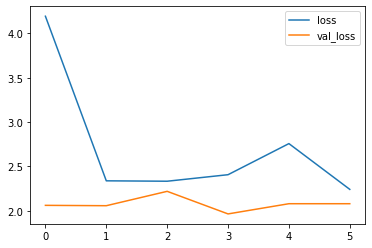

In [108]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [109]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [110]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 70%


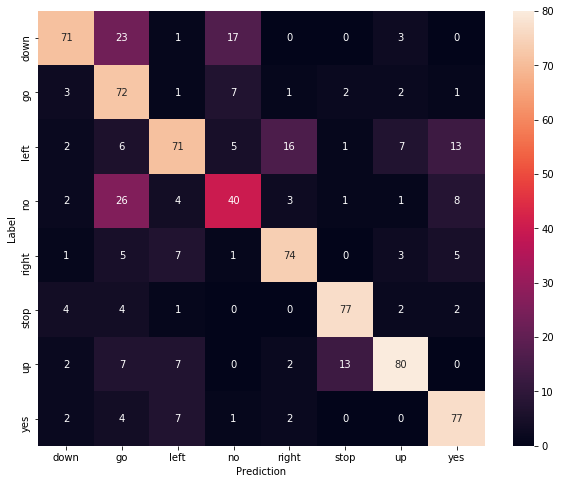

In [111]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Извлечение фичей вида "положение - среднее - дисперсия"

In [112]:
def extract_agg_gaussian(arr):
    arr_, ind_ = local_extract_peaks(arr)
    out_list = []
    for i in np.sort(ind_):
        mean_, var_, _, _ = gaussian_fit(arr_, i)
        out_list.append(mean_)
        out_list.append(var_)
        out_list.append(i / 64)
    
    return np.array(out_list)

In [113]:
print(extract_agg_gaussian(feat_[:1].numpy().flatten()))

[2.14443356e-05 9.25814664e-11 1.56250000e-02 1.42559219e-05
 5.73469269e-11 1.87500000e-01 1.36540798e-05 3.49350997e-11
 2.26562500e-01]


In [114]:
def agg_gaussian_apply(waveform, label):
    inp_arr = waveform.numpy()
    features_init = get_fourier(waveform)
    features = tf.convert_to_tensor(np.apply_along_axis(extract_agg_gaussian, 1, features_init), dtype=tf.float32)
    
    label_id = tf.argmax(label == commands)
    
    del inp_arr

    return features, label_id

In [115]:
def agg_gaussian_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = agg_gaussian_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = tf.reshape(wv, shape=(270,))
    return wv, lbl

In [116]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = agg_gaussian_outside_function(waveform, label)
  print(wv.shape, label_)

(270,) tf.Tensor(4, shape=(), dtype=int64)


In [117]:
def agg_gauss_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(agg_gaussian_outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [118]:
gauss_train_ds = agg_gauss_preprocess_dataset(train_files)
gauss_val_ds = agg_gauss_preprocess_dataset(val_files)
gauss_test_ds = agg_gauss_preprocess_dataset(test_files)

gauss_whole_ds = agg_gauss_preprocess_dataset(filenames)

In [119]:
batch_size = 64
gauss_train_ds = gauss_train_ds.batch(batch_size)
gauss_val_ds = gauss_val_ds.batch(batch_size)

In [120]:
gauss_train_ds = gauss_train_ds.cache().prefetch(AUTOTUNE)
gauss_val_ds = gauss_val_ds.cache().prefetch(AUTOTUNE)
print(gauss_whole_ds.take(1))

<TakeDataset shapes: ((270,), <unknown>), types: (tf.float32, tf.int64)>


In [121]:
def plot_gauss_features(features, ax):
  features = tf.reshape(features, shape = (30, 9))
  height = features.shape[0]
  width = features.shape[1]
  X = np.linspace(0, np.size(features), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, features)

<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


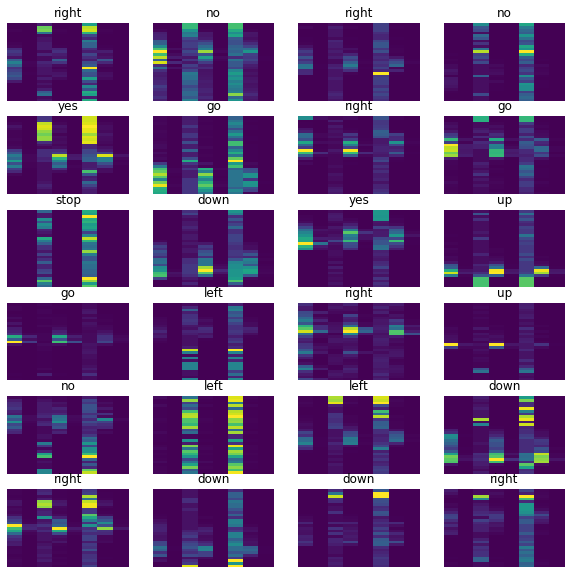

In [122]:
rows = 6
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (features, label_id) in enumerate(gauss_whole_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_gauss_features(features.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [123]:
for elem, _ in gauss_whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (270,)
8


### Обучение модели

Размерность входного вектора - 1116 (124 * 9 - количество окон X количество фичей)

In [124]:
model_g = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(270, activation='relu', name = 'dense_init'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu', name = 'dense_256'),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu', name = 'dense_128'),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu', name = 'dense_128_2'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu', name = 'dense_64'),
    layers.Dropout(0.15),
    layers.Dense(num_labels, activation = 'softmax', name = 'softmax')
])

model_g.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_init (Dense)          (None, 270)               73170     
                                                                 
 dropout_14 (Dropout)        (None, 270)               0         
                                                                 
 dense_256 (Dense)           (None, 256)               69376     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_128 (Dense)           (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_128_2 (Dense)         (None, 128)              

In [125]:
model_g.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [126]:
EPOCHS = 10
history = model_g.fit(
    gauss_train_ds, 
    validation_data=gauss_val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


100/100 [==============================] - 276s 3s/step - loss: 1.8871 - categorical_accuracy: 0.1006 - val_loss: 1.6569 - val_categorical_accuracy: 0.1612
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.6114 - categorical_accuracy: 0.0897 - val_loss: 1.5202 - val_categorical_accuracy: 0.1550
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 1.4674 - categorical_accuracy: 0.0844 - val_loss: 1.4329 - val_categorical_accuracy: 0.1412
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 1.3730 - categorical_accuracy: 0.0811 - val_loss: 1.4504 - val_categorical_accuracy: 0.1275
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 1.2770 - categorical_accuracy: 0.0798 - val_loss: 1.4103 - val_categorical_accuracy: 0.1213
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 1.2183 - categorical_accuracy: 0.0839 - val_loss: 1.3839 - val_categorical_accuracy: 0.1100
Epoch 7/10
100

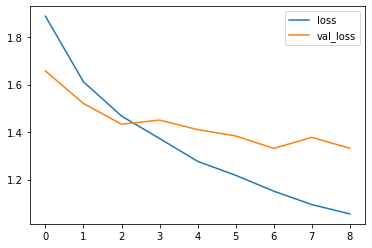

In [127]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [128]:
test_audio = []
test_labels = []

for audio, label in gauss_test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


In [129]:
y_pred = np.argmax(model_g.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 54%


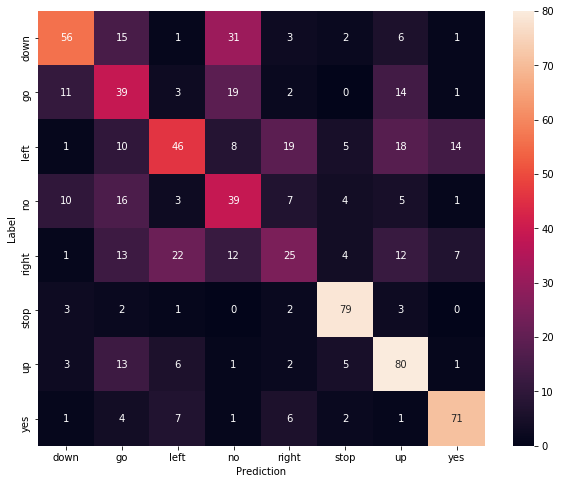

In [130]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

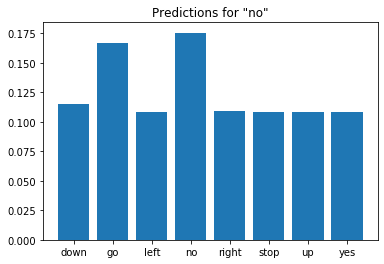

In [131]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = filter_peaks_stft_preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

### Обучение CNN - использование сверточных слоёв для поиска паттернов в feature maps

Подготовка оберточной функции

In [132]:
def agg_gaussian_conv_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = agg_gaussian_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = wv[..., tf.newaxis]
    wv = tf.reshape(wv, shape = (30, 9, 1))
    return wv, lbl

In [133]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = agg_gaussian_conv_outside_function(waveform, label)
  print(wv.shape, label_)

(30, 9, 1) tf.Tensor(4, shape=(), dtype=int64)


In [134]:
def agg_gauss_conv_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(agg_gaussian_conv_outside_function)
  return output_ds

In [135]:
conv_gauss_train_ds = agg_gauss_conv_preprocess_dataset(train_files)
conv_gauss_val_ds = agg_gauss_conv_preprocess_dataset(val_files)
conv_gauss_test_ds = agg_gauss_conv_preprocess_dataset(test_files)

conv_gauss_whole_ds = agg_gauss_conv_preprocess_dataset(filenames)

In [136]:
batch_size = 64
conv_gauss_train_ds = conv_gauss_train_ds.batch(batch_size)
conv_gauss_val_ds = conv_gauss_val_ds.batch(batch_size)

In [137]:
conv_gauss_train_ds = conv_gauss_train_ds.cache().prefetch(AUTOTUNE)
conv_gauss_val_ds = conv_gauss_val_ds.cache().prefetch(AUTOTUNE)
print(conv_gauss_whole_ds.take(1))

<TakeDataset shapes: ((30, 9, 1), <unknown>), types: (tf.float32, tf.int64)>


In [138]:
for elem, _ in conv_gauss_whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (30, 9, 1)
8


In [139]:
model_c = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size = (5, 3), strides = (1, 1), activation='relu'),
    layers.Conv2D(64, kernel_size = (4, 4), strides = (1, 1), activation='relu'),
    layers.MaxPooling2D(pool_size = (4, 4)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

model_c.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 7, 32)         512       
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 4, 64)         32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_19 (Dropout)        (None, 5, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               41088     
                                                      

In [140]:
model_c.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [141]:
EPOCHS = 10
history = model_c.fit(
    conv_gauss_train_ds, 
    validation_data=conv_gauss_val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


100/100 [==============================] - 194s 2s/step - loss: 1.9994 - categorical_accuracy: 0.0988 - val_loss: 1.8510 - val_categorical_accuracy: 0.0362
Epoch 2/10
100/100 [==============================] - 4s 36ms/step - loss: 1.8200 - categorical_accuracy: 0.0887 - val_loss: 1.7158 - val_categorical_accuracy: 0.0550
Epoch 3/10
100/100 [==============================] - 4s 38ms/step - loss: 1.7365 - categorical_accuracy: 0.0834 - val_loss: 1.6488 - val_categorical_accuracy: 0.1312
Epoch 4/10
100/100 [==============================] - 4s 38ms/step - loss: 1.6610 - categorical_accuracy: 0.0917 - val_loss: 1.5573 - val_categorical_accuracy: 0.1112
Epoch 5/10
100/100 [==============================] - 3s 35ms/step - loss: 1.5735 - categorical_accuracy: 0.0828 - val_loss: 1.5047 - val_categorical_accuracy: 0.0800
Epoch 6/10
100/100 [==============================] - 3s 35ms/step - loss: 1.5008 - categorical_accuracy: 0.0838 - val_loss: 1.4315 - val_categorical_accuracy: 0.0938
Epoch 7/1

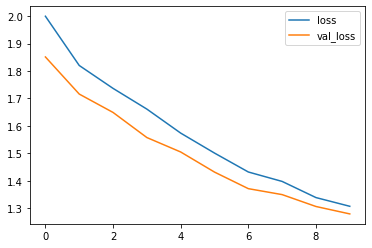

In [142]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [143]:
test_audio = []
test_labels = []

for audio, label in conv_gauss_test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


In [144]:
y_pred = np.argmax(model_c.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 55%


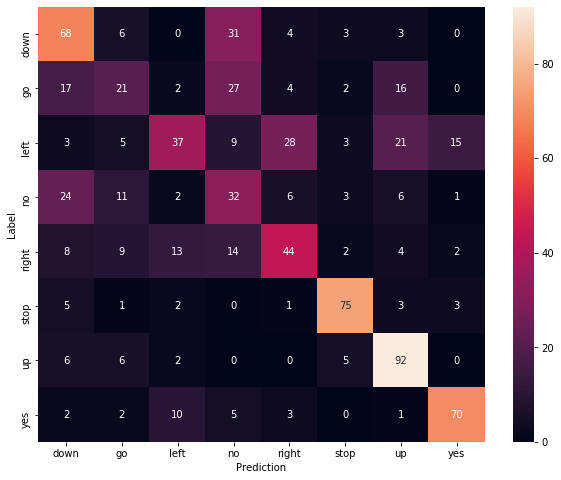

In [145]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Исследование формант через Power Spectral Density

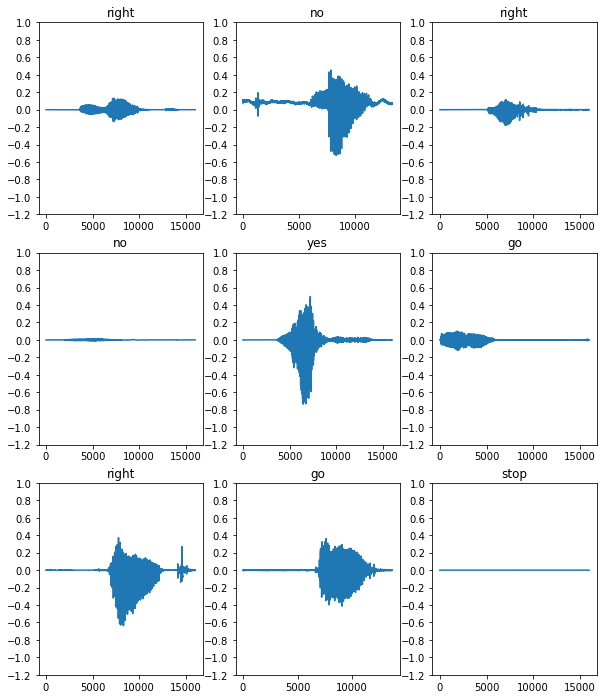

In [146]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [147]:
def get_psd(waveform, nperseg_):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  inp = equal_length.numpy().flatten()
  x, y = welch(inp, nperseg = nperseg_)

  return x, y

In [148]:
for waveform, _ in waveform_ds.take(1):
    get_psd(waveform, 1024)

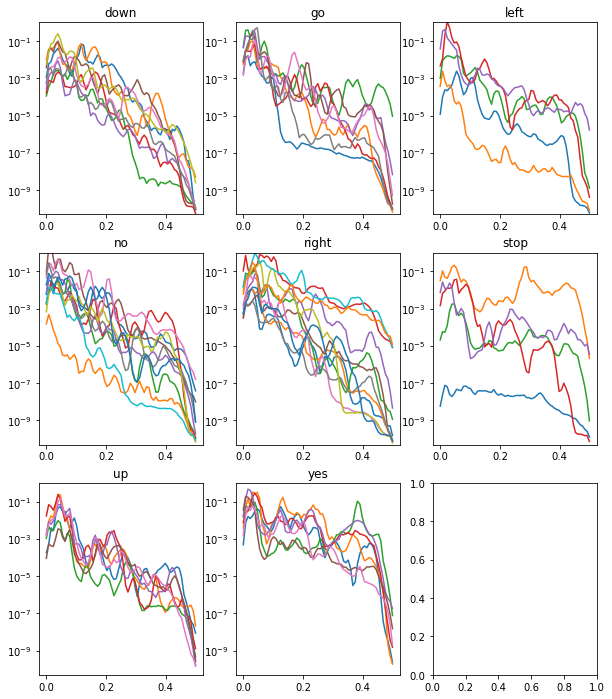

In [150]:
rows = 3
cols = 3
n = 8
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, com in enumerate(commands):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.set_ylim([0.5e-10, 1])
    label = com
    ax.set_title(label)

    for audio, label in waveform_ds.take(64):
        if label.numpy().decode('UTF-8') == com:
            x, y = get_psd(audio, 128)
            ax.semilogy(x, y)

plt.show()

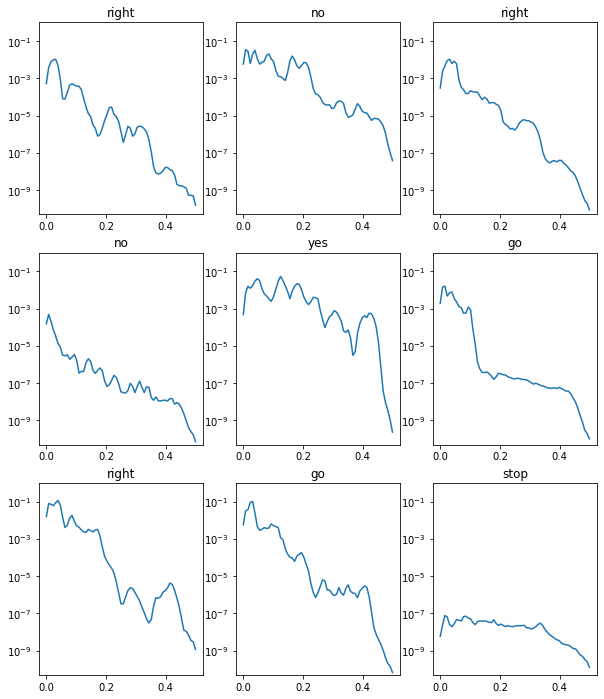

In [153]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  x, y = get_psd(audio, 128)
  ax.set_ylim([0.5e-10, 1])
  ax.semilogy(x, y)
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [154]:
def extract_agg_gaussian_channels(arr):
    arr_, ind_ = local_extract_peaks(arr)
    out_arr = np.ndarray((3, 3), dtype=np.float32)
    for i, x_ in enumerate(np.sort(ind_)):
        mean_, var_, _, _ = gaussian_fit(arr_, i)
        out_arr[0, i] = mean_
        out_arr[1, i] = var_
        out_arr[2, i] = x_ / 128

    return out_arr

In [155]:
print(extract_agg_gaussian_channels(feat_[:1].numpy().flatten()))

[[2.6114243e-05 2.3707827e-05 2.1444335e-05]
 [7.1492548e-11 8.0357360e-11 9.2581463e-11]
 [1.5625000e-02 1.8750000e-01 2.2656250e-01]]


In [156]:
def agg_gaussian_apply_channels(waveform, label):
    inp_arr = waveform.numpy()
    features_init = get_fourier(waveform)
    features = tf.convert_to_tensor(
                np.apply_along_axis(
                        extract_agg_gaussian_channels, 1, 
                        features_init), 
                dtype=tf.float32)
    
    label_id = tf.argmax(label == commands)

    del inp_arr

    return features, label_id

In [170]:
def agg_gaussian_chan_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = agg_gaussian_apply_channels, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = tf.reshape(wv, shape=(30, 3, 3))
    return wv, lbl

In [171]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = agg_gaussian_chan_outside_function(waveform, label)
  wv = tf.reshape(wv, (30, 3, 3))
  print(wv.shape, label_)

(30, 3, 3) tf.Tensor(4, shape=(), dtype=int64)


<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


In [172]:
def agg_gauss_conv_ch_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(agg_gaussian_chan_outside_function)
  return output_ds

In [173]:
chconv_gauss_train_ds = agg_gauss_conv_ch_preprocess_dataset(train_files)
chconv_gauss_val_ds = agg_gauss_conv_ch_preprocess_dataset(val_files)
chconv_gauss_test_ds = agg_gauss_conv_ch_preprocess_dataset(test_files)

chconv_gauss_whole_ds = agg_gauss_conv_ch_preprocess_dataset(filenames)

In [174]:
batch_size = 64
chconv_gauss_train_ds = chconv_gauss_train_ds.batch(batch_size)
chconv_gauss_val_ds = chconv_gauss_val_ds.batch(batch_size)

In [175]:
chconv_gauss_train_ds = chconv_gauss_train_ds.cache().prefetch(AUTOTUNE)
chconv_gauss_val_ds = chconv_gauss_val_ds.cache().prefetch(AUTOTUNE)
print(chconv_gauss_whole_ds.take(1))

<TakeDataset shapes: ((30, 3, 3), <unknown>), types: (tf.float32, tf.int64)>


In [176]:
for elem, _ in chconv_gauss_whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (30, 3, 3)
8


<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


In [190]:
model_ch = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(32, kernel_size = 3, strides = 1, activation='relu'),
    #layers.Conv2D(32, kernel_size = (3, 3), strides = (1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(960, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_labels, activation='softmax')
])

model_ch.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 30, 1, 32)         320       
                                                                 
 flatten_13 (Flatten)        (None, 960)               0         
                                                                 
 dense_38 (Dense)            (None, 960)               922560    
                                                                 
 dropout_48 (Dropout)        (None, 960)               0         
                                                                 
 dense_39 (Dense)            (None, 256)               246016    
                                                                 
 dropout_49 (Dropout)        (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 128)             

In [191]:
model_ch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [192]:
EPOCHS = 10
history = model_ch.fit(
    chconv_gauss_train_ds, 
    validation_data=chconv_gauss_val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


100/100 [==============================] - 281s 3s/step - loss: 1.9707 - categorical_accuracy: 0.0958 - val_loss: 1.7436 - val_categorical_accuracy: 0.1587
Epoch 2/10
100/100 [==============================] - 5s 53ms/step - loss: 1.7202 - categorical_accuracy: 0.0834 - val_loss: 1.5935 - val_categorical_accuracy: 0.1325
Epoch 3/10
100/100 [==============================] - 7s 65ms/step - loss: 1.6004 - categorical_accuracy: 0.0792 - val_loss: 1.4880 - val_categorical_accuracy: 0.1125
Epoch 4/10
100/100 [==============================] - 6s 60ms/step - loss: 1.5113 - categorical_accuracy: 0.0798 - val_loss: 1.4361 - val_categorical_accuracy: 0.1050
Epoch 5/10
100/100 [==============================] - 5s 49ms/step - loss: 1.4254 - categorical_accuracy: 0.0873 - val_loss: 1.4147 - val_categorical_accuracy: 0.1125
Epoch 6/10
100/100 [==============================] - 5s 46ms/step - loss: 1.3626 - categorical_accuracy: 0.0798 - val_loss: 1.3496 - val_categorical_accuracy: 0.0875
Epoch 7/1

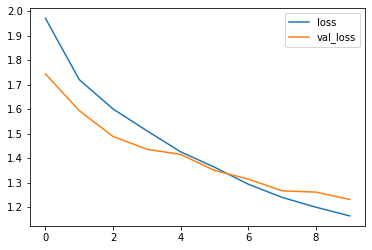

In [193]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [195]:
test_audio = []
test_labels = []

for audio, label in chconv_gauss_test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-70-e1fda2a84661>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


In [198]:
y_pred = np.argmax(model_ch.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 56%


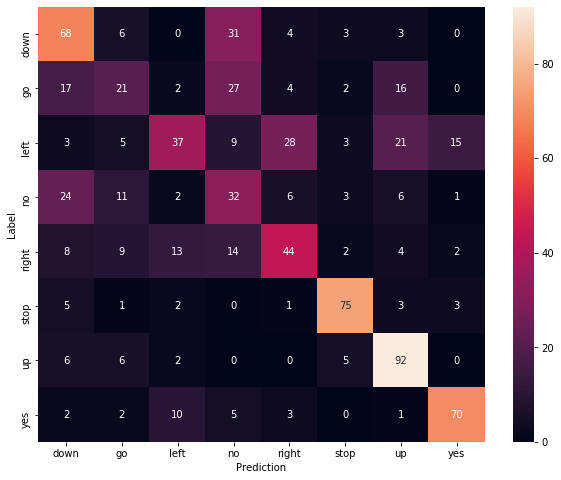

In [196]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()